In [55]:
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import time
import re
import math
from matplotlib import pyplot as plt
import tensorflow as tf
# import wandb
# from wandb.keras import WandbCallback

path = "/home/andrew/ros_ws/src/2020T1_competition/controller/prev"
labels = ['00', '01', '02', '10', '11', '12'] # one label representing each combination of foward and turning

In [56]:
img_sets = []
from random import randint

# load and augment dataset
for filename in os.listdir(path):
    if filename.endswith(".jpg"): 
        label = filename.split('_')[0]
        img = np.array(Image.open(path+"/"+filename))
        img_sets.append(np.array([[img, labels.index(label)]]))

        # todo: make this less ugly
        # h, w = img.shape
        # img = img.reshape(h, w, 1)
        # img_aug = tf.keras.preprocessing.image.apply_affine_transform(img, theta=randint(-2,2), tx=0,
        #                                                         ty=0, shear=randint(-10,10), row_axis=0, col_axis=1,
        #                                                         fill_mode='nearest', cval=0.0, order=1)
        # img_aug = img.reshape(h, w)
        # img_sets.append(np.array([[img_aug, labels.index(label)]]))
                                                                


10998
5
(90, 160)


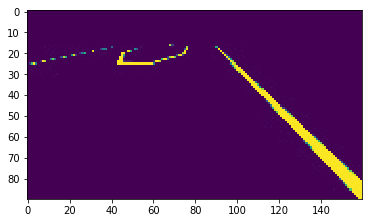

In [57]:
# making sure things are cool and good
n = 100
plt.imshow(img_sets[n][0][0])
plt.show
print(len(img_sets))
print(img_sets[n][0][1])
print(img_sets[n][0][0].shape)

In [58]:
all_dataset = np.concatenate(img_sets, axis=0)
np.random.shuffle(all_dataset)

In [59]:
X_dataset_orig = np.array([data[0] for data in all_dataset[:]])
Y_dataset_orig = np.array([[data[1]] for data in all_dataset]).T

NUMBER_OF_LABELS = 6
CONFIDENCE_THRESHOLD = 0.01

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
  
# Normalize X (images) dataset
X_dataset = X_dataset_orig/255.

# Convert Y dataset to one-hot encoding
Y_dataset = convert_to_one_hot(Y_dataset_orig, NUMBER_OF_LABELS).T

In [60]:
n, h, w = X_dataset.shape
X_dataset = X_dataset.reshape(n, h, w, 1)
print(X_dataset.shape)

(10998, 90, 160, 1)


In [61]:
VALIDATION_SPLIT = 0.2

print("Total examples: {}\nTraining examples: {}\nTest examples: {}".
      format(X_dataset.shape[0],
             math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT)),
             math.floor(X_dataset.shape[0] * VALIDATION_SPLIT)))
print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))

Total examples: 10998
Training examples: 8799.0
Test examples: 2199.0
X shape: (10998, 90, 160, 1)
Y shape: (10998, 6)


In [62]:
# model setup 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [63]:
def reset_weights(model):
    session = backend.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [64]:
# input_shape needs to match the input, duh
conv_model = models.Sequential()
# this creates our convolution kernel, (3,3) is the size of it
conv_model.add(layers.Conv2D(12, (3, 3), activation='relu',
                             input_shape=(h, w, 1)))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(36, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(36*36, activation='relu'))
conv_model.add(layers.Dense(36*36, activation='relu'))
conv_model.add(layers.Dense(6, activation='softmax'))

In [65]:
conv_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 88, 158, 12)       120       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 44, 79, 12)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 77, 36)        3924      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 38, 36)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 19, 36, 36)        11700     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 18, 36)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5832)             

In [66]:
reset_weights(conv_model)

In [67]:
# wandb.init(project='enph353', entity='nullcline')
# config = wandb.config

In [68]:
lr= 1e-4
# config = wandb.config
# config.learning_rate = lr

conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=lr),
                   metrics=['acc'])

In [69]:
history_conv = conv_model.fit(X_dataset, Y_dataset, 
                              validation_split=VALIDATION_SPLIT, 
                              epochs=10, 
                              batch_size=123)
                            #

Train on 8798 samples, validate on 2200 samples
Epoch 1/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.3439 - acc: 0.8819 - val_loss: 0.2172 - val_acc: 0.9227
Epoch 2/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.2205 - acc: 0.9250 - val_loss: 0.2179 - val_acc: 0.9291
Epoch 3/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.2106 - acc: 0.9275 - val_loss: 0.2480 - val_acc: 0.9173
Epoch 4/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.1967 - acc: 0.9298 - val_loss: 0.1854 - val_acc: 0.9377
Epoch 5/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.1910 - acc: 0.9316 - val_loss: 0.1832 - val_acc: 0.9377
Epoch 6/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.1884 - acc: 0.9294 - val_loss: 0.1966 - val_acc: 0.9295
Epoch 7/10
8798/8798 [==============================] - 26s 3ms/sample - loss: 0.1804 - acc: 0.9351 - val_loss: 0.1800 - val_acc: 

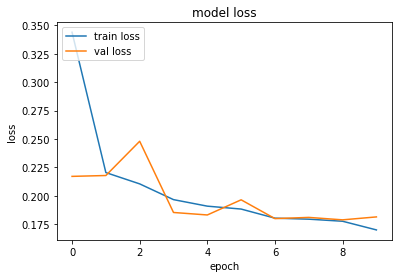

In [70]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

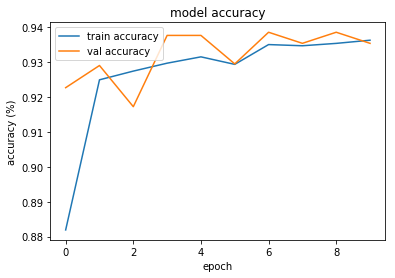

In [71]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [72]:
conv_model.save('./models/OLv1.h5')